In [ ]:
!unzip '235670_소설 작가 분류 AI 경진대회_data.zip' # https://dacon.io/competitions/official/235670/data

Archive:  235670_소설 작가 분류 AI 경진대회_data.zip
  inflating: sample_submission.csv   
  inflating: test_x.csv              
  inflating: train.csv               


** 이번주차는 비정형 데이터의 전처리부터 예측까지 다루기 위해 위 대회의 베이스라인을 변형하여 가져왔습니다. https://dacon.io/competitions/official/235670/codeshare/1738?page=1&dtype=recent *** 

+ https://tutorials.pytorch.kr/intermediate/char_rnn_classification_tutorial 
keras인 베이스코드를 변경하기 위해 파이토치 튜토리얼을 참고했습니다


# 라이브러리 import/기본 설정

In [ ]:
import os
import torch 
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import random

import pandas as pd
import re

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
# 하이퍼파라미터
batch_size = 64
lr = 0.001
epochs = 50

# 데이터 불러오기

In [ ]:
#파일 불러오기
train = pd.read_csv('train.csv', encoding = 'utf-8') #한글의 경우 encoding으로 utf-8, ms949,cp949
test = pd.read_csv('test_x.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('sample_submission.csv', encoding = 'utf-8')

In [ ]:
'''
 총 5명의 작가, 그리고 작가의 글에서 일부 발췌한 내용 
 대회 끝나고 누군지 말해준다고 했는데 누군지 찾을 수가 없음 몹시 궁금함..
 '''


train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [ ]:
train.iloc[0,1]

'He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; looked at odin, and was in evident perplexity.'

In [ ]:
pd.DataFrame(sample_submission.iloc[0,:]) # 5명의 작가(target var)

,0
index,0
0,0
1,0
2,0
3,0
4,0


#전처리

1. 정규표현식 

 문장을 원하는 조건으로 수정하기
  ex. 문장에서 영어만 뽑아내기/ 영어 숫자만 뽑아내기 등

  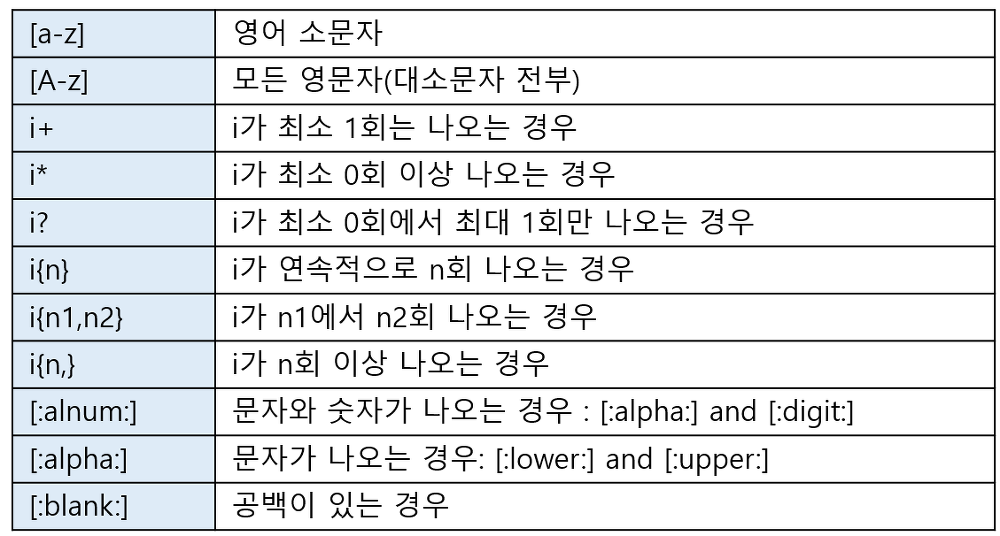

  https://wikidocs.net/4308 에서 다양한 식을 소개하고 있으니 참고

In [ ]:
#부호를 제거해주는 함수
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

train['text']=train['text'].apply(alpha_num)

In [ ]:
train.iloc[0,1]# 문장 부호가 모두 없어진 것을 확인할 수 있음 

'He was almost choking There was so much so much he wanted to say but strange exclamations were all that came from his lips The Pole gazed fixedly at him at the bundle of notes in his hand looked at odin and was in evident perplexity'

2. 불용어 제거하기

 반복적으로 많이 등장하는 단어에 어떤 의미가 없을 경우  
 한글을 예로 들었을 때, '이' '그리고' '그러나' '했다' 등

 흔히 불용어 사전을 만들고, 그 사전에 있는 단어를 데이터에서 지우는 형태로 불용어를 제거함. 아래의 stopwords 리스트가 그 예

  그렇다면 그 stopwords는 어떻게 가져오는가?

 (1) 

  한글 불용어를 정리해 놓은 링크 https://www.ranks.nl/stopwords/korean
  위 링크를 이용하여 제거

  (2) nltk 라는 자연어 처리 라이브러리에서 제공하는 것 이용

 아래는 nltk를 이용함
 


In [ ]:
import nltk
from nltk.corpus import stopwords 

nltk.download('stopwords')
stopwords = stopwords.words('english')

print(stopwords[:10])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


3. 토큰화 : 텍스트를 쪼개는 것

- 문장
- 단어
- 형태소

 다양한 기준으로 텍스트를 쪼갤 수 있으니 각자의 목적에 맞게 고를 것   
 특히 한글의 경우 단어로 쪼갤 것인지, 형태소로 쪼갤 것인지에 대한 고민 필요

영어는 보통 띄어쓰기로

In [ ]:
!pip install konlpy
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
from konlpy.tag import Mecab

text = "대보름 날에 다들 소원 비셨나요?"
tokenizer = Mecab()
print(tokenizer.morphs(text))

['대', '보름', '날', '에', '다', '들', '소원', '비', '셨', '나요', '?']


In [ ]:
from nltk.tokenize import TreebankWordTokenizer

tokenizer = TreebankWordTokenizer()

text = "대보름 날에 다들 소원 비셨나요?"
tokenizer.tokenize(text)

['대보름', '날에', '다들', '소원', '비셨나요', '?']

In [ ]:
def remove_stopwords(text):
    final_text = []
    words = tokenizer.tokenize(text)
    for word in words:
        if word.strip().lower() not in stopwords:
          final_text.append(word.strip())
    return  " ".join(final_text)


train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

기존 : 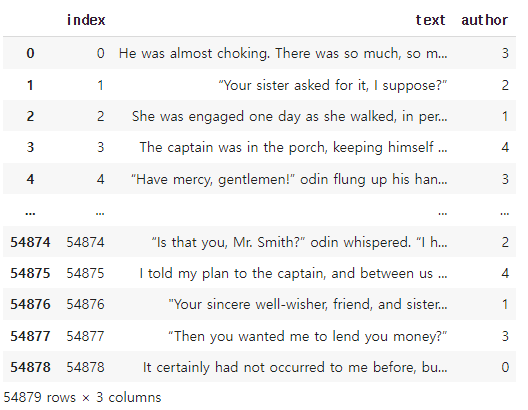

In [ ]:
train

,index,text,author
0,0,almost choking much much wanted say strange ex...,3
1,1,sister asked suppose,2
2,2,engaged one day walked perusing janes last let...,1
3,3,captain porch keeping carefully way treacherou...,4
4,4,mercy gentlemen odin flung hands dont write an...,3
...,...,...,...
54874,54874,mr smith odin whispered hardly dared hope woul...,2
54875,54875,told plan captain us settled details accomplis...,4
54876,54876,sincere wellwisher friend sister lucy odin,1
54877,54877,wanted lend money,3


4-1 . 카운터 기반 임베딩

컴퓨터가 알아들을 수 있도록 문자를 벡터로 바꾸어줌

- 원핫 인코딩
간단한 방법, 그러나 매우 sparse 한 행렬 -> inefficient

- 카운트 기반 인코딩(BoG 등): tf-idf

여기서는 tf-idf 이용

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer(max_features = 200) # max_features를 통해 최대 몇 개의 단어를 벡터로 바꿀 것인지 결정합니다. 참고 max_features 설정 안 했더니 제 커널은 죽었어요ㅠㅠ
v.fit(train['text']) # test 때는 train 에서 학습된 tf-idf를 이용해야 하기 때문에 여기서는 fit_transform을 한꺼번에 쓰는 대신, 나눠서 이용합니다 ~ sklearn에서 여타 모델들과 마찬가지로 생각하시면 됩니다

TfidfVectorizer(max_features=200)

In [ ]:
print(v.vocabulary_) # 벡터화된 단어들 사전

{'almost': 0, 'much': 113, 'say': 147, 'came': 19, 'hand': 63, 'looked': 92, 'odin': 121, 'asked': 9, 'one': 125, 'day': 26, 'last': 79, 'letter': 85, 'mr': 111, 'saw': 146, 'looking': 93, 'away': 10, 'said': 144, 'way': 185, 'turned': 178, 'us': 182, 'take': 164, 'side': 153, 'hands': 64, 'men': 103, 'dont': 31, 'heart': 68, 'oh': 123, 'god': 56, 'well': 186, 'another': 4, 'time': 174, 'man': 98, 'little': 89, 'yet': 198, 'see': 148, 'great': 61, 'upon': 181, 'would': 194, 'two': 179, 'could': 23, 'put': 134, 'though': 171, 'night': 119, 'must': 114, 'ask': 8, 'cried': 25, 'may': 101, 'years': 196, 'always': 2, 'house': 72, 'new': 117, 'began': 12, 'things': 169, 'knew': 76, 'want': 184, 'next': 118, 'morning': 109, 'moment': 107, 'think': 170, 'end': 34, 'thought': 172, 'quite': 136, 'still': 159, 'ever': 38, 'table': 163, 'passed': 128, 'already': 1, 'indeed': 75, 'come': 22, 'back': 11, 'took': 177, 'long': 90, 'returned': 140, 'many': 99, 'old': 124, 'really': 138, 'even': 36, 'fe

In [ ]:
x = v.transform(train['text']).toarray()
print(x)

[[0.39448743 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.5468209  0.         0.        ]]


In [ ]:
print(x.shape) # 200개의 max 단어를 설정했기 때문에 문장수, 단어수 이렇게 array를 만들어진 것을 확인할 수 있다
print(train.shape)

(54879, 200)
(54879, 3)


In [ ]:
x = pd.DataFrame(x)
temp = []
for i in range(len(x)):
  temp.append(list(x.iloc[i,:]))
train['preprocessed_text'] = temp

In [ ]:
train

,index,text,author,preprocessed_text
0,0,almost choking much much wanted say strange ex...,3,"[0.3944874313763683, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,sister asked suppose,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,engaged one day walked perusing janes last let...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,captain porch keeping carefully way treacherou...,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,mercy gentlemen odin flung hands dont write an...,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
54874,54874,mr smith odin whispered hardly dared hope woul...,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
54875,54875,told plan captain us settled details accomplis...,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
54876,54876,sincere wellwisher friend sister lucy odin,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
54877,54877,wanted lend money,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


4-2워드 임베딩


위의 tf-idf 는 단순히 카운트를 기반으로 matrix를 만듭니다  

하지만 단어와 단어 사이에서 그 의미가 달라질 수도 있습니다  
이걸 고려하기 위해서 나온 또다른 벡터화/임배딩 방법이 워드 임배딩입니다  

torch모델에서 임배딩도 학습하게 하는 구문이 있으므로 그걸 보면서 하도록 합시다

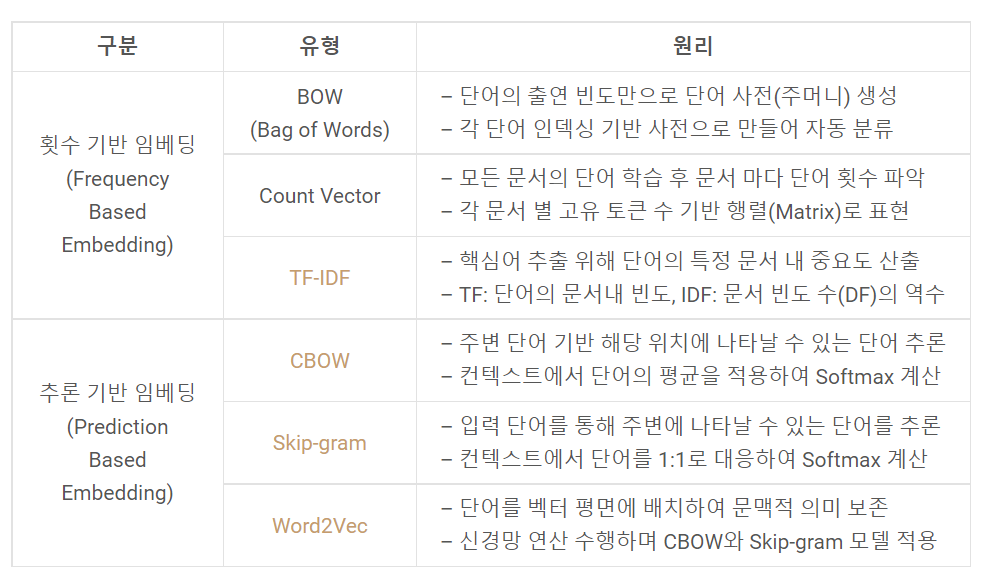


In [ ]:
word_set = []
max_len = 0

for d in train['text']:
  word_set = word_set + d.split(' ') # 여기에 토큰화한 데이터가 들어가면 됩니다
  if len(d.split()) > max_len:
    max_len = len(d.split())
  
word_set = set(word_set)



In [ ]:
word_to_idx = {word: i+1 for i, word in enumerate(word_set)}
print(len(word_set))
print(max_len)

47120
212


In [ ]:
def word_to_key(text):
  final_text = []
  for word in text.split():
      final_text.append(word_to_idx[word])
  if len(final_text) < max_len:
    final_text = final_text + [0] * (max_len - len(final_text))
  return final_text


train['word_to_key'] = train['text'].apply(word_to_key)

In [ ]:
train

,index,text,author,preprocessed_text,word_to_key
0,0,almost choking much much wanted say strange ex...,3,"[0.3944874313763683, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[26242, 39678, 673, 673, 24524, 28268, 12754, ..."
1,1,sister asked suppose,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[10797, 23757, 31209, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,engaged one day walked perusing janes last let...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[18984, 29388, 18280, 39880, 2840, 15444, 4319..."
3,3,captain porch keeping carefully way treacherou...,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[33257, 19470, 30258, 17276, 14334, 46776, 422..."
4,4,mercy gentlemen odin flung hands dont write an...,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[23063, 13436, 23556, 5818, 32601, 39695, 3076..."
...,...,...,...,...,...
54874,54874,mr smith odin whispered hardly dared hope woul...,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[44789, 22095, 23556, 12683, 4013, 36384, 3005..."
54875,54875,told plan captain us settled details accomplis...,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[7859, 38408, 33257, 21300, 26020, 16975, 1580..."
54876,54876,sincere wellwisher friend sister lucy odin,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[32852, 22020, 29226, 10797, 2780, 23556, 0, 0..."
54877,54877,wanted lend money,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[24524, 34805, 30055, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# 모델

전처리 분량이 너무 길었죠..?ㅎㅎ

In [ ]:
X_train = train.iloc[:45000, 4]
X_test = train.iloc[45000:, 4].reset_index(drop=True)

y_train = train.iloc[:45000, 2]
y_test = train.iloc[45000:, 2].reset_index(drop=True)

In [ ]:
class CustomDataset(Dataset):
  def __init__(self):
    
    self.x_data = X_train
    self.y_data = [[y] for y in y_train]

  def __len__(self):

    return len(self.x_data)

  def __getitem__(self, idx):

    x = torch.LongTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)

    return x,y

In [ ]:
class CustomDataset_test(Dataset):
  def __init__(self):
    
    self.x_data = X_test
    self.y_data = [[y] for y in y_test]

  def __len__(self):

    return len(self.x_data)

  def __getitem__(self, idx):

    x = torch.LongTensor(self.x_data[idx])
    y = torch.LongTensor(self.y_data[idx])

    return x,y

In [ ]:
dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) #sampler를 만들었다면, sampler를 파라미터로 넣어줄 수 있음 : https://hyelimkungkung.tistory.com/29?category=935193 참고 ㅎㅎ

In [ ]:
# 여기서 혹시 gru를 써보고 싶다면 주석을 풀고 시행하면 됩니다. 

class RNN(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
      super(RNN, self).__init__()
      self.n_layers = n_layers
      self.hidden_dim = hidden_dim

      self.embed = nn.Embedding(n_vocab, embed_dim)
      self.dropout = nn.Dropout(dropout_p)
      # self.gru = nn.GRU(embed_dim, self.hidden_dim,
      #                  num_layers=self.n_layers,
      #                  batch_first=True)
      self.rnn = nn.RNN(embed_dim, self.hidden_dim,batch_first = True)
      self.out = nn.Sequential(
          nn.Linear(self.hidden_dim, n_classes),
          nn.Softmax()
      )
    def forward(self, x):
      x = self.embed(x)
      h_0 = self._init_state(batch_size=x.size(0)) # 첫번째 히든 스테이트를 0벡터로 초기화
      #x, _ = self.gru(x, h_0)  # GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)
      x, _ = self.rnn(x,h_0)
      h_t = x[:,-1,:] # (배치 크기, 은닉 상태의 크기)의 텐서로 크기가 변경됨. 즉, 마지막 time-step의 은닉 상태만 가져온다.
      self.dropout(h_t)
      logit = self.out(h_t)  # (배치 크기, 은닉 상태의 크기) -> (배치 크기, 출력층의 크기)
      return logit

    def _init_state(self, batch_size=1):
      weight = next(self.parameters()).data
      return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

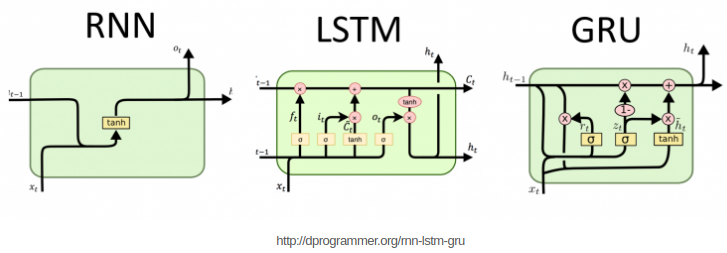

In [ ]:
n_vocab = 47120+1
embedd_size = 5
hidden_size = 100
output_size = 5

In [ ]:
net = RNN(1, 256, n_vocab, embedd_size, output_size, 0.5).to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr)

In [ ]:
losses = []
for epoch in range(epochs):
  
  for x, y in dataloader:
    optimizer.zero_grad()
    y = y.to(device)

    # forward 연산
    hypothesis = net(x)

    # 비용 함수
    y = y.squeeze()
    cost = criterion(hypothesis, y)
    cost.backward()
    optimizer.step()
    losses.append(cost.item()) # 값만 가져오기 위해서 .item()

  # 10의 배수에 해당되는 에포크마다 비용을 출력
  if epoch % 10 == 0:
      print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.5120916366577148
10 1.4886783361434937
20 1.5114006996154785
30 1.4936578273773193
40 1.4933736324310303


In [ ]:
dataset = CustomDataset_test()
test_loader = DataLoader(dataset, batch_size=batch_size)

In [ ]:
correct = 0

with torch.no_grad():
  net = net.to('cpu')
  net.eval()
  for data, target in test_loader:
    data, target = data, target
    output = net(data)
    
    pred = output.max(1, keepdim=True)[1]
    # eq() 함수는 값이 일치하면 1을, 아니면 0을 출력.
    correct += pred.eq(target.view_as(pred)).sum().item()

test_accuracy = correct / len(test_loader.dataset)
print('Accuracy:', test_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy: 0.2575159429092013


In [ ]:
pred

tensor([[3],
        [3],
        [3],
        [3],
        [3],
        [2],
        [3],
        [2],
        [3],
        [2],
        [2],
        [2],
        [2],
        [3],
        [3],
        [3],
        [3],
        [2],
        [3],
        [2],
        [3],
        [3],
        [3]])

In [ ]:
output

tensor([[4.6063e-01, 1.1852e-06, 4.9726e-02, 4.8964e-01, 3.9088e-06],
        [4.6063e-01, 1.1852e-06, 4.9726e-02, 4.8964e-01, 3.9088e-06],
        [4.6063e-01, 1.1852e-06, 4.9726e-02, 4.8964e-01, 3.9088e-06],
        [4.6063e-01, 1.1852e-06, 4.9726e-02, 4.8964e-01, 3.9088e-06],
        [4.6063e-01, 1.1852e-06, 4.9726e-02, 4.8964e-01, 3.9088e-06],
        [1.6921e-01, 1.6064e-06, 4.8948e-01, 3.4130e-01, 5.4303e-06],
        [4.6063e-01, 1.1852e-06, 4.9726e-02, 4.8964e-01, 3.9088e-06],
        [1.6921e-01, 1.6064e-06, 4.8948e-01, 3.4130e-01, 5.4303e-06],
        [4.6063e-01, 1.1852e-06, 4.9726e-02, 4.8964e-01, 3.9088e-06],
        [1.6921e-01, 1.6064e-06, 4.8948e-01, 3.4130e-01, 5.4303e-06],
        [1.6921e-01, 1.6064e-06, 4.8948e-01, 3.4130e-01, 5.4303e-06],
        [1.6921e-01, 1.6064e-06, 4.8948e-01, 3.4130e-01, 5.4303e-06],
        [1.6921e-01, 1.6064e-06, 4.8948e-01, 3.4130e-01, 5.4303e-06],
        [4.6063e-01, 1.1852e-06, 4.9726e-02, 4.8964e-01, 3.9088e-06],
        [4.6063e-01,

## 다음주 과제 

 - 본 데이터 셋도 좋고, 다른 데이터 셋도 좋습니다
 - 하지만 기왕이면 raw 데이터를 다루어보면 좋을 것 같습니다. 

 - 전처리에서도 
 - 모델에서도 자유롭게 해보세요

 - 제가 정확도가 너무 낮은 모델을 만들었는데... 여러분도 높은 모델을 만들 필요는 없습니다! 에러 없이 다 돌아가게 하는 것도 벅차더라고요 저는...



---



 - 형식/ 제출 방식

  제출은 github에 다음주 화 - 수요일까지 해주세요!   
  6주차 폴더 안에 6주차_혦


> 요약한 내용을 commit description 이나 ipynb 서두에 적어주세요 


---

- 발표

 제출된 것들 중   
  (1) auc가 높은 것   
  (2) 흥미로운 시도  
기준으로 3 건을 뽑아서 발표하도록 하겠습니다!  모두가 업로드 한 시점으로부터 최대한 빠르게 발표할 사람을 알려드리도록 할께요!   
발표는 위에서 필수 사항 + 코드 로 중심으로 간단하게 해주시면 됩니다 기타 발표 자료는 추가 사항입니다 



하다가 질문 생기면 편하게 말씀해주세요~  



